In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
import tbparse

In [2]:
path = "../../../logs/femnist-clustering/"

In [3]:
from tbparse import SummaryReader

def tb_log_to_df(log_dir):
    reader = SummaryReader(log_dir)
    df = reader.scalars
    

In [4]:
def process_df(df, name):
    df = df.rename({'value': name, 'step': 'Round'}, axis='columns')
    df = df.drop(['tag'], axis='columns')
    df = df.set_index('Round')
    return df

In [5]:
def extract_logs(log_dir, tag):
    # load logs
    strategies = {0: "testencoding-AE", 1: "testencoding-FashionMNIST", 2: "testencoding-StyleExtraction", 3: "ifca", 4: "fedavg"}
    readers = [SummaryReader(f"{log_dir}{strategies[i]}") for i in range(len(strategies))]
    scalars = [reader.scalars for reader in readers]
    accs = [scalar.loc[scalar.tag == tag] for scalar in scalars]
    
    # extract acc per strategy
    enc_AE = accs[0]
    enc_fashion = accs[1]
    enc_style = accs[2]
    ifca = accs[3]
    fedavg = accs[4]

    # process df
    enc_AE = process_df(enc_AE, 'Ours (Federated)')
    enc_fashion = process_df(enc_fashion, 'Ours (Centralized)')
    enc_style = process_df(enc_style, 'LADD')
    ifca = process_df(ifca, 'IFCA')
    fedavg = process_df(fedavg, 'FedAvg')

    acc = enc_AE \
        .join(enc_fashion) \
        .join(enc_style) \
        .join(ifca) \
        .join(fedavg)

    return acc

In [6]:
def extract_pre_training_logs(log_dir):
    strategy = "ae-pretraining"
    reader = SummaryReader(f'{log_dir}{strategy}')
    scalar = reader.scalars
    time = scalar.loc[scalar.tag == "System/training_round_time"]
    time = process_df(time, 'Pre-Training')[1:].mean()*20
    bytes_rcv = scalar.loc[scalar.tag == "System/bytes_rcv"].iloc[-1:]['value']
    bytes_sent = scalar.loc[scalar.tag == "System/bytes_sent"].iloc[-1:]['value']

    return time, bytes_rcv, bytes_sent

In [7]:
def get_system_metrics(path):
    training_round_time = extract_logs(path, "System/training_round_time").drop_duplicates()[1:].mean()
    bytes_rcv = extract_logs(path, "System/bytes_rcv").drop_duplicates().iloc[-1:]
    bytes_sent = extract_logs(path, "System/bytes_sent").drop_duplicates().iloc[-1:]

    return training_round_time, bytes_rcv, bytes_sent

In [8]:
def get_clustering_time(path):
    clustering_time = extract_logs(path, "System/clustering_time").drop_duplicates().fillna(0)
    return clustering_time

In [9]:
def plot_scenario(acc, scenario_title, y_lim, n_strategies, saving_name):
    ax = sns.lineplot(data=acc.iloc[:, :n_strategies])
    sns.set(rc={'figure.figsize':(6, 3)})
    sns.set_theme(style="white", palette="tab10")
    
    ax.set(ylabel='Testing accuracy')
    ax.set(ylim=y_lim)
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.figure.suptitle(scenario_title)
    plt.setp(ax.get_legend().get_texts(), family='serif') # for legend text
    
    plt.savefig(saving_name, bbox_inches='tight')

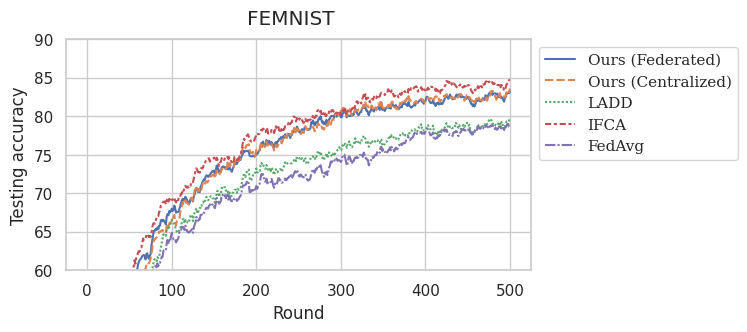

In [11]:
sns.set_theme(style="whitegrid")
acc = extract_logs(path, "Training/federated_accuracy")
acc_smoothed = acc.ewm(span=10).mean()
plot_scenario(acc_smoothed, 'FEMNIST', (60,90), 5, 'accuracy')

In [12]:
# Rounds to target accuracy
strategies = {0: "Ours (Federated)", 1: "Ours (Centralized)", 2: "LADD", 3: "IFCA", 4: "FedAvg"}
for _, strategy in strategies.items():
    indices = acc.index[acc[strategy] > 80].tolist()
    if len(indices) == 0:
        print(strategy, 'Not reached')
    else:
        print(strategy, indices[0])

Ours (Federated) 248
Ours (Centralized) 243
LADD 392
IFCA 212
FedAvg 418


In [13]:
# Average accuracy of the last 5 training rounds
acc.iloc[-25:].mean()

Ours (Federated)      82.806348
Ours (Centralized)    83.051974
LADD                  79.088016
IFCA                  84.180686
FedAvg                78.674825
dtype: float64

In [14]:
time_pre_training, bytes_rcv_pre_training, bytes_sent_pre_training = extract_pre_training_logs(path) 

/tmp/ipykernel_20946/214366148.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  communication_total['Ours (Federated)'][500] += bytes_rcv_pre_training
/tmp/ipykernel_20946/214366148.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  communication_total['Ours (Federated)'][500] += bytes_sent_pre_training


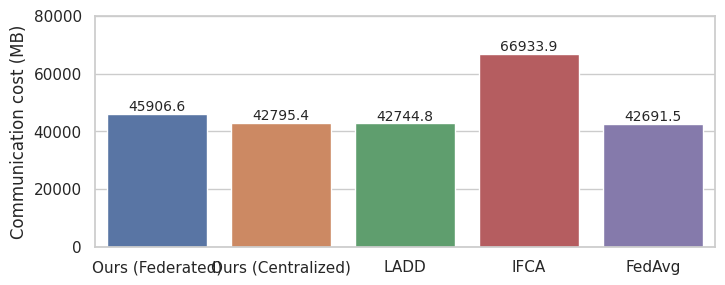

In [15]:
round_time, bytes_rcv, bytes_sent = get_system_metrics(path)

communication_total = bytes_sent + bytes_rcv
communication_total['Ours (Federated)'][500] += bytes_rcv_pre_training
communication_total['Ours (Federated)'][500] += bytes_sent_pre_training

sns.set(rc={'figure.figsize':(8, 3)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(communication_total)
ax.set(ylabel='Communication cost (MB)')

for container in ax.containers:
    ax.bar_label(container, fontsize=10)

ax.set_ylim((0,80000))
plt.savefig('communication_cost', bbox_inches='tight')

In [16]:
pre_training = extract_pre_training_logs(path)
clustering_time = get_clustering_time(path)
total_time = round_time * 500 + clustering_time.iloc[0]
total_time['Ours (Federated)'] += pre_training[0]
total_time = pd.DataFrame(total_time).transpose()

/tmp/ipykernel_20946/2869774048.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  total_time['Ours (Federated)'] += pre_training[0]


(0.0, 400.0)

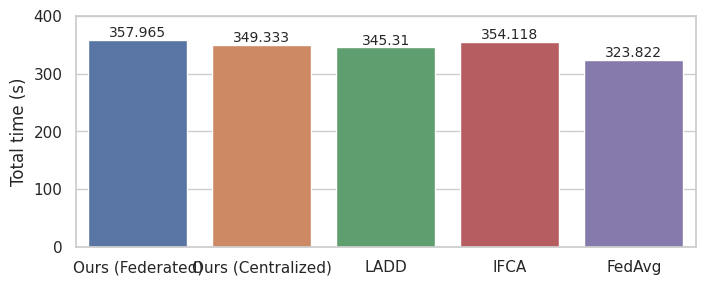

In [17]:
sns.set(rc={'figure.figsize':(8, 3)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(total_time)
ax.set(ylabel='Total time (s)')
for container in ax.containers:
    ax.bar_label(container, fontsize=10)

ax.set_ylim((0,400))